In [1]:
%matplotlib notebook
import pylab
pylab.rcParams['figure.figsize'] = (8, 4)
from pylab import *

# The Humble Gumbel Distribution

A few weeks ago, I was looking through OpenAI's implementation of A2C. The final step in A2C is to generate an action for the agent by sampling from a categorical probability distribution over possible discrete actions. Usually, I've done this with `np.random.choice`, but OpenAI's implementation was doing it a completely different way. Looking at [utils.py](https://github.com/openai/baselines/blob/98257ef8c9bd23a24a330731ae54ed086d9ce4a7/baselines/a2c/utils.py#L8-L10), we have:

In [2]:
def sample(logits):
    noise = tf.random_uniform(tf.shape(logits))
    return tf.argmax(logits - tf.log(-tf.log(noise)), 1)

This _sort of_ makes sense. If you just take the argmax of the logits, you would always just sample the highest-probability action. So instead, you add some noise to the logits to make things more random, and _then_ take the argmax. But why not just use `noise`? Why `-tf.log(-tf.log(noise))`?

There's another strange thing. Usually we sample from the distribution created by passing the logits through a softmax function. If we sample using noise on only the logits, does it give the same results?

It turns out this is a clever way of sampling _directly_ from softmax distribution using noise from a special distribution: the _Gumbel_ distribution. Let's explore what this is all about.

<img src="humble.png">

## The Gumbel distribution

The Gumbel distribution is a probability distribution with density function

$$p(x) = \frac{1}{\beta} exp(-z - exp[-z])$$ where $$z = \frac{x - \mu}{\beta}.$$

On its own, the Gumbel distribution is typically used to model the maximum of a set of independent samples. For example, let's say you want to quantify how much ice cream you eat per day. Assume your hunger for ice cream is normally-distributed, with a mean of 5/10. You record your hunger 100 times a day for 10,000 days. (We also assume your hunger is erratic enough that all samples are independent.) You make a note of the maximum hunger you experience every day.

The distribution of daily maximum hunger would then follow a Gumbel distribution.

<IPython.core.display.Javascript object>


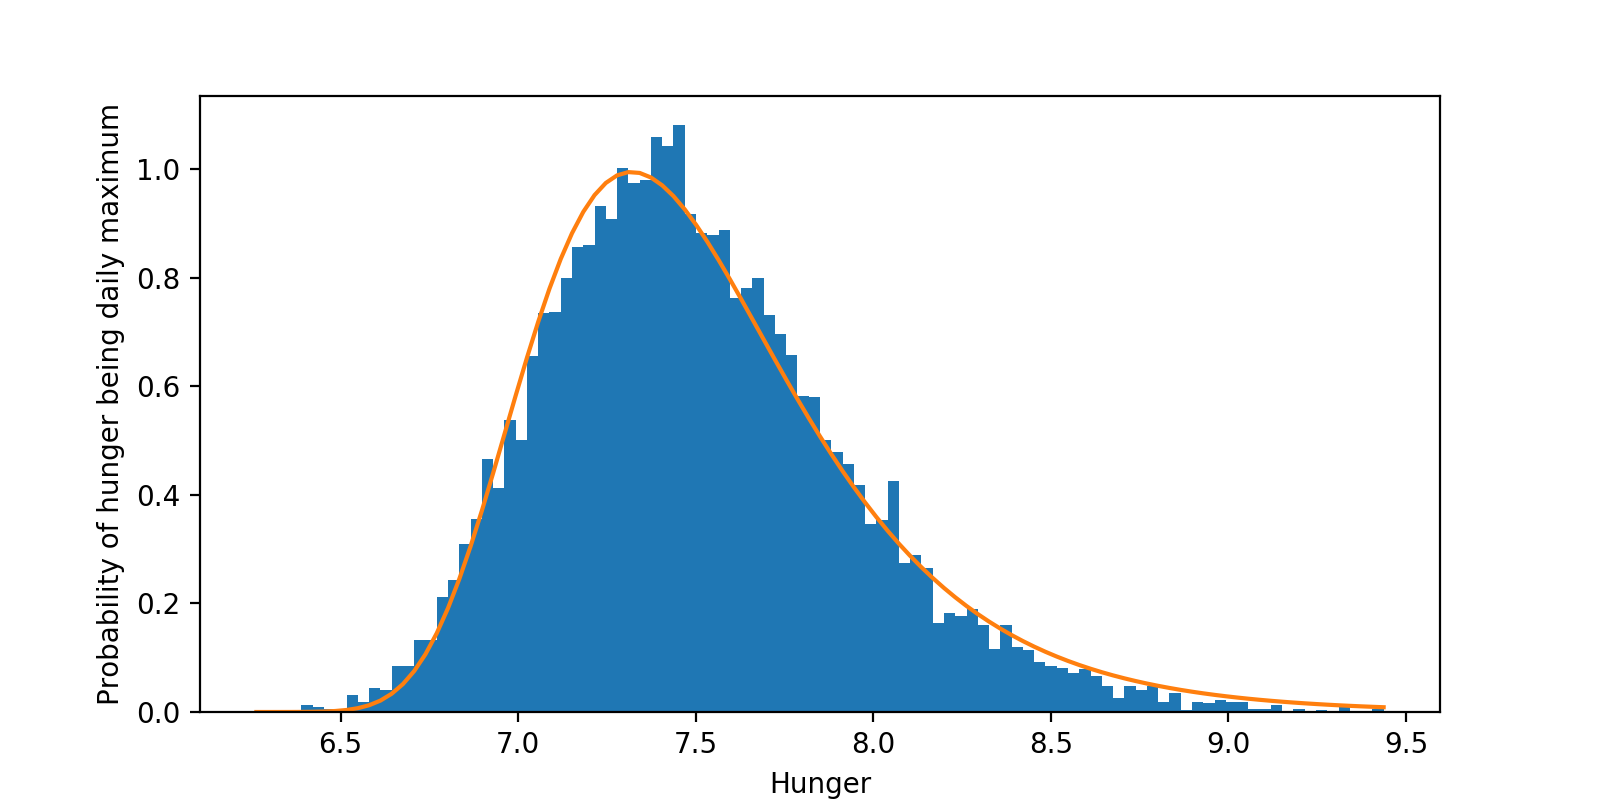

In [3]:
from scipy.optimize import curve_fit

mean_hunger = 5
samples_per_day = 100
n_days = 10000
samples = np.random.normal(loc=mean_hunger, size=(n_days, samples_per_day))
daily_maxes = np.max(samples, axis=1)

def gumbel_pdf(prob, loc, scale):
    z = (prob - loc) / scale
    return exp(-z - exp(-z)) / scale

def plot_maxes(daily_maxes):
    probs, hungers, _ = hist(daily_maxes, density=True, bins=100)
    xlabel("Hunger")
    ylabel("Probability of hunger being daily maximum")
    
    (loc, scale), _ = curve_fit(gumbel_pdf, hungers[:-1], probs)
    plot(hungers, gumbel_pdf(hungers, loc, scale))

figure()
plot_maxes(daily_maxes)

From what I understand<sup>[1](http://www.well.ox.ac.uk/dtc/McVeanStats/L1_distributions.ppt)</sup>, the Gumbel distribution should be a good fit when the underlying data is distributed according to either a normal or an exponential distribution. To convince ourselves, let's try again with exponentially-distributed hunger:

<IPython.core.display.Javascript object>


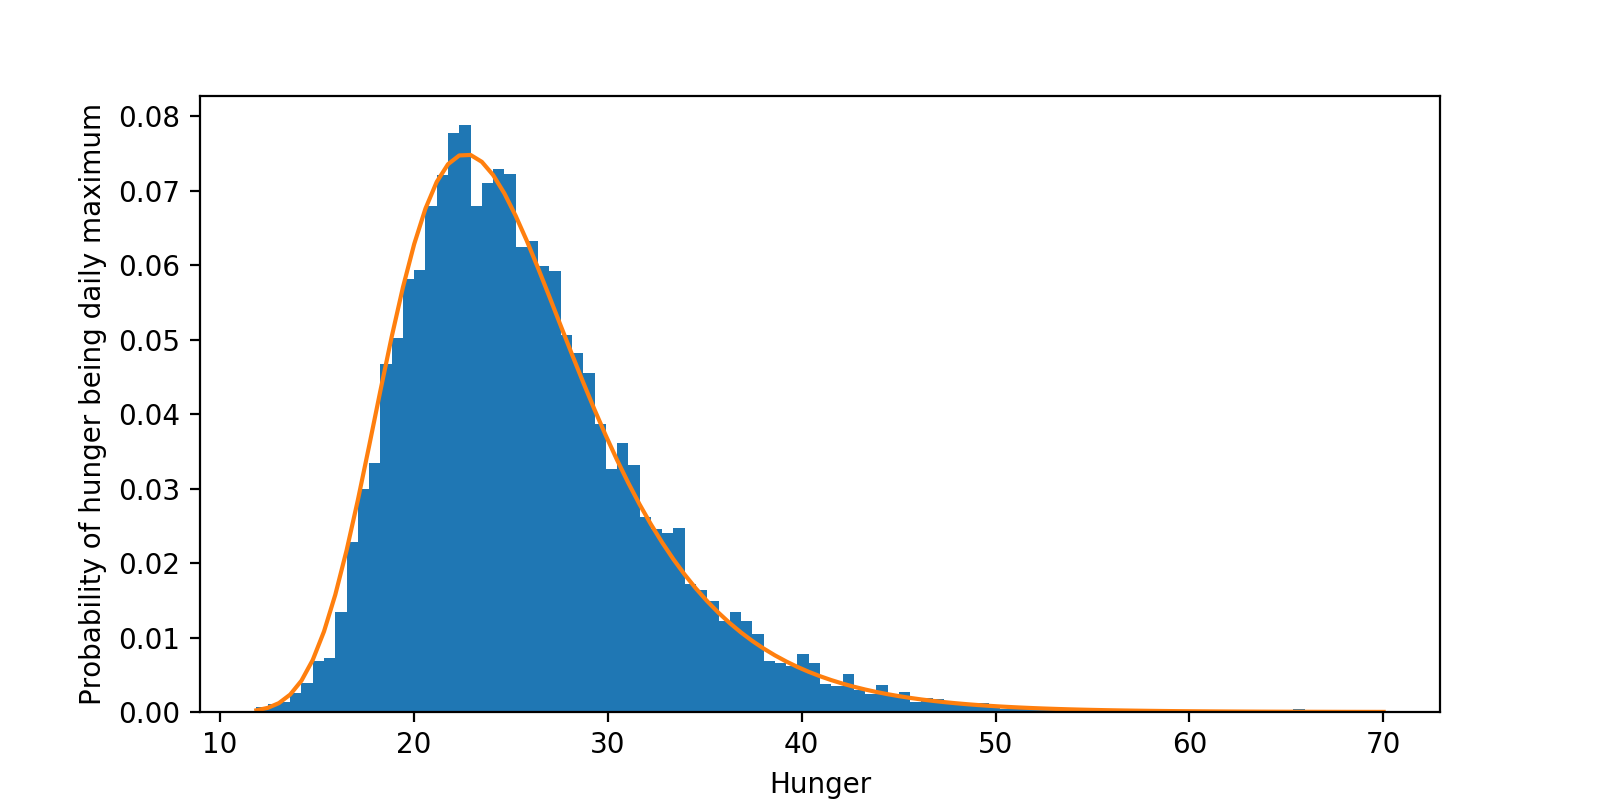

In [4]:
most_likely_hunger = 5
samples = np.random.exponential(scale=most_likely_hunger,
                                size=(n_days, samples_per_day))
daily_maxes = np.max(samples, axis=1)

figure()
plot_maxes(daily_maxes)

Sure enough, the distribution of maximum daily hunger values is still Gumbel-distributed.

## The Gumbel-max trick

What does the Gumbel distribution have to do with sampling from a categorical distribution?

To experiment, let's set up a distribution to work with.

<IPython.core.display.Javascript object>


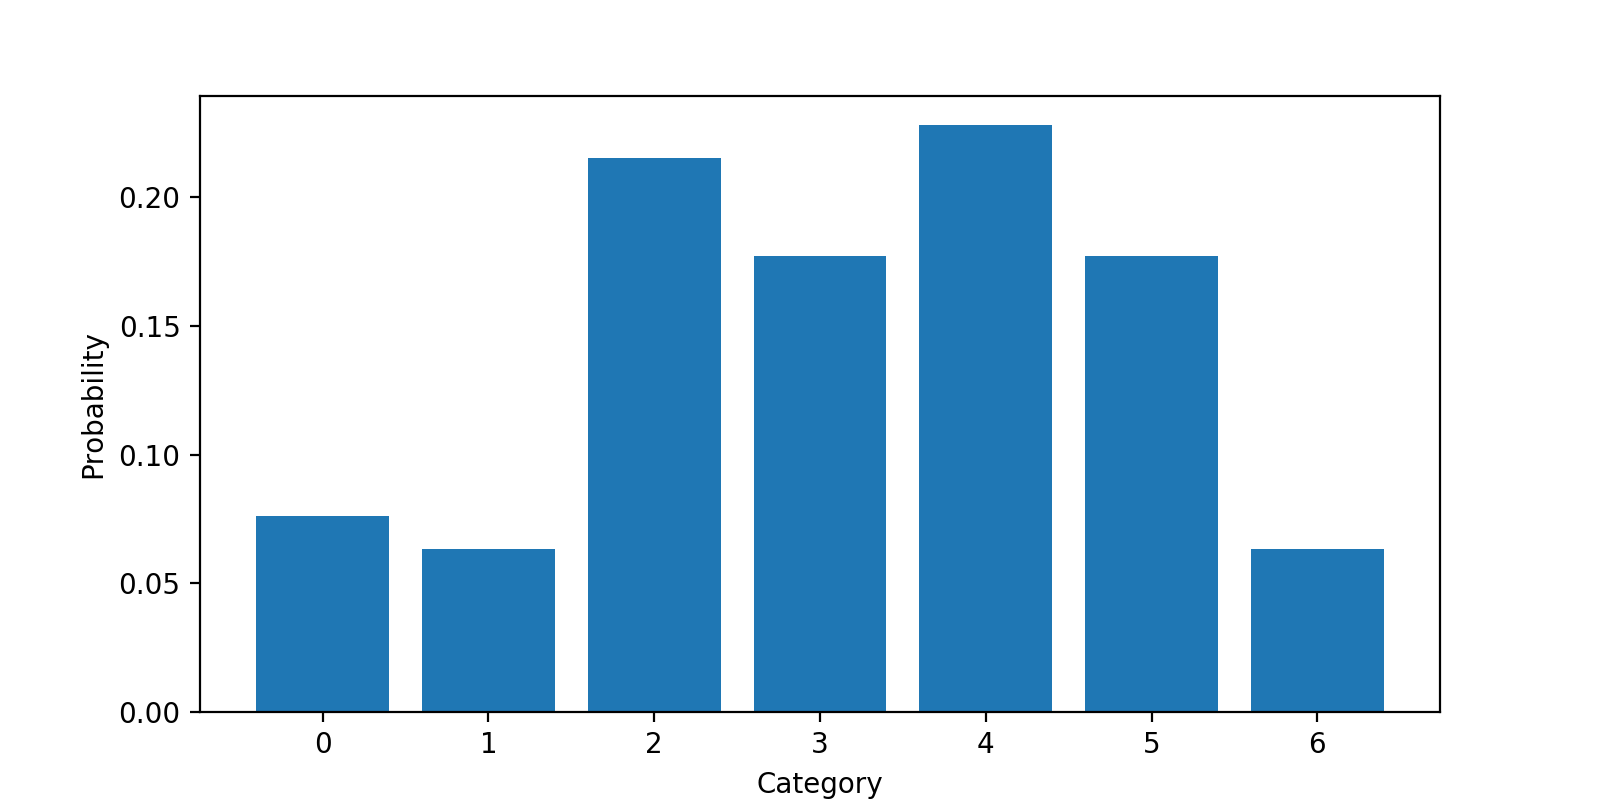

In [5]:
n_cats = 7
cats = np.arange(n_cats)

probs = np.random.randint(low=1, high=20, size=n_cats)
probs = probs / sum(probs)
logits = log(probs)

def plot_probs():
    bar(cats, probs)
    xlabel("Category")
    ylabel("Probability")
    
figure()
plot_probs()

As a sanity check, let's try sampling with `np.random.choice`. Do we get the right probabilities?

<IPython.core.display.Javascript object>


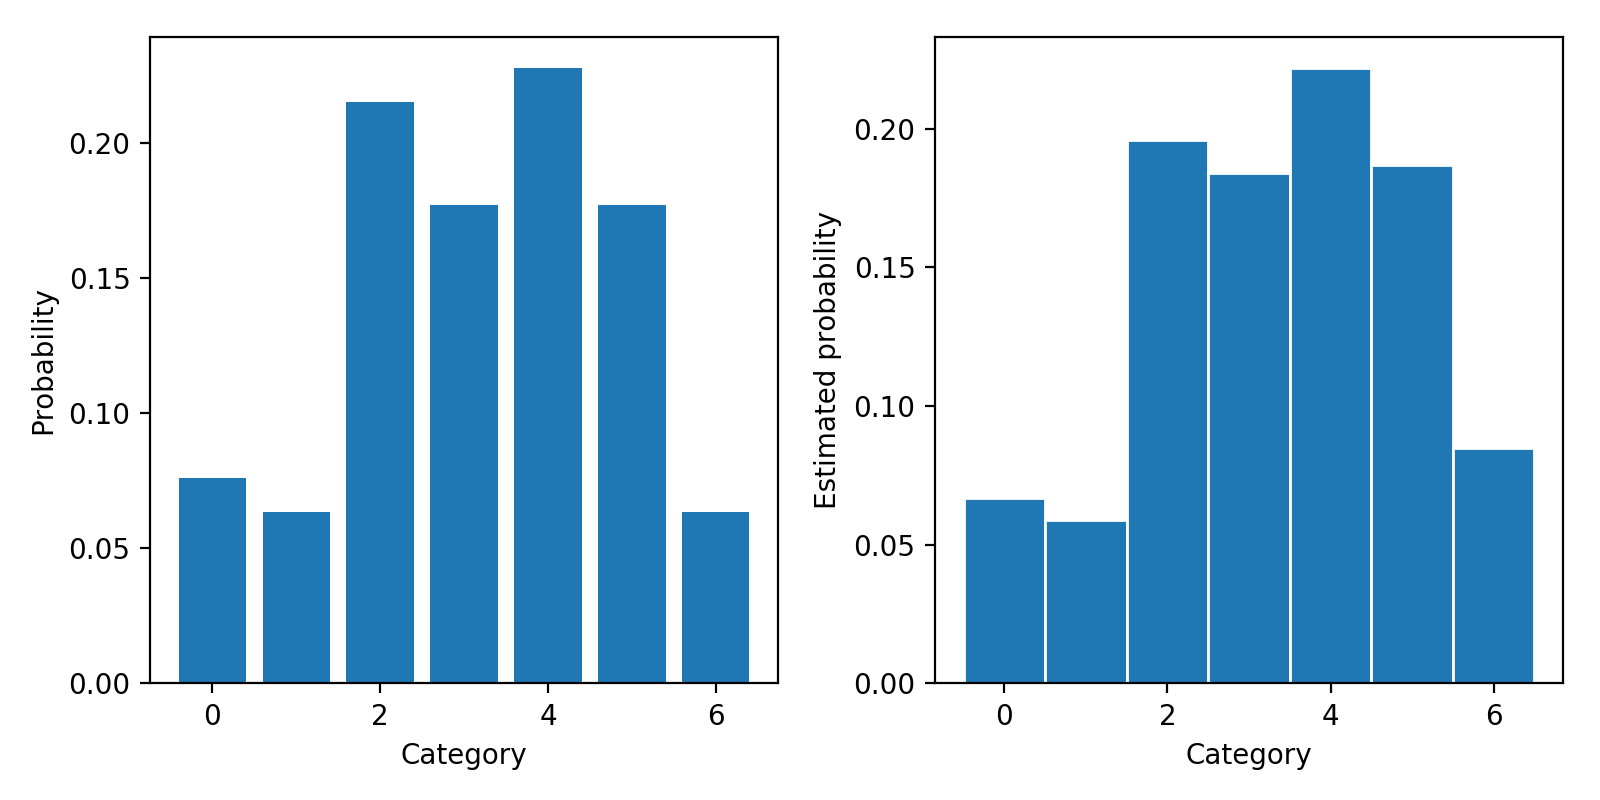

Original probabilities:		0.08 0.06 0.22 0.18 0.23 0.18 0.06
Estimated probabilities:	0.07 0.06 0.20 0.18 0.22 0.19 0.09


In [6]:
n_samples = 1000

def plot_estimated_probs(samples):
    n_cats = np.max(samples) + 1
    estd_probs, _, _ = hist(samples,
                            bins=np.arange(n_cats + 1),
                            align='left',
                            edgecolor='white',
                            density=True)
    xlabel("Category")
    ylabel("Estimated probability")
    return estd_probs

def print_probs(probs):
    print(" ".join(["{:.2f}"] * len(probs)).format(*probs))

samples = np.random.choice(cats, p=probs, size=n_samples)

figure()
subplot(1, 2, 1)
plot_probs()
subplot(1, 2, 2)
estd_probs = plot_estimated_probs(samples)
tight_layout()

print("Original probabilities:\t\t", end="")
print_probs(probs)
print("Estimated probabilities:\t", end="")
print_probs(estd_probs)

Looks good.

### Sampling with noise

Let's return to OpenAI's interesting way of sampling:

In [7]:
def sample(logits):
    noise = tf.random_uniform(tf.shape(logits))
    return tf.argmax(logits - tf.log(-tf.log(noise)), 1)

We had some intuition that maybe this works by just using some noise to "shake up" the argmax.

Will any noise do? Let's try a couple of different types.

### Uniform noise

<IPython.core.display.Javascript object>


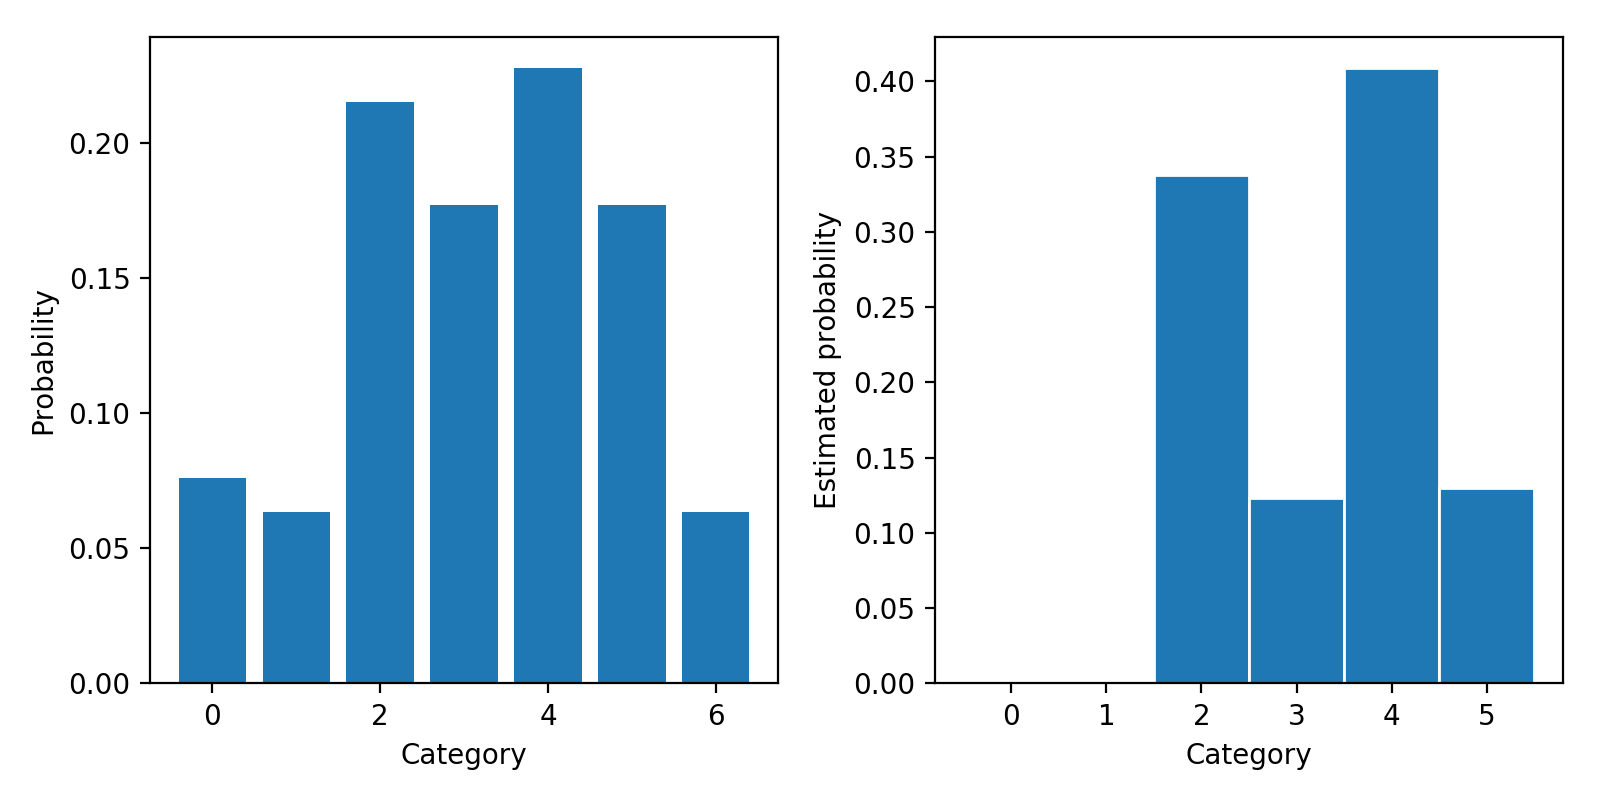

Original probabilities:		0.08 0.06 0.22 0.18 0.23 0.18 0.06
Estimated probabilities:	0.00 0.00 0.34 0.12 0.41 0.13


In [8]:
def sample(logits):
    noise = np.random.uniform(size=len(logits))
    sample = np.argmax(logits + noise)
    return sample

samples = [sample(logits) for _ in range(n_samples)]

figure()
subplot(1, 2, 1)
plot_probs()
subplot(1, 2, 2)
estd_probs = plot_estimated_probs(samples)
tight_layout()

print("Original probabilities:\t\t", end="")
print_probs(probs)
print("Estimated probabilities:\t", end="")
print_probs(estd_probs)

So uniform noise seems to capture the modes of the distribution, but distorted. It also completely misses out all the other categories.

### Normal noise

<IPython.core.display.Javascript object>


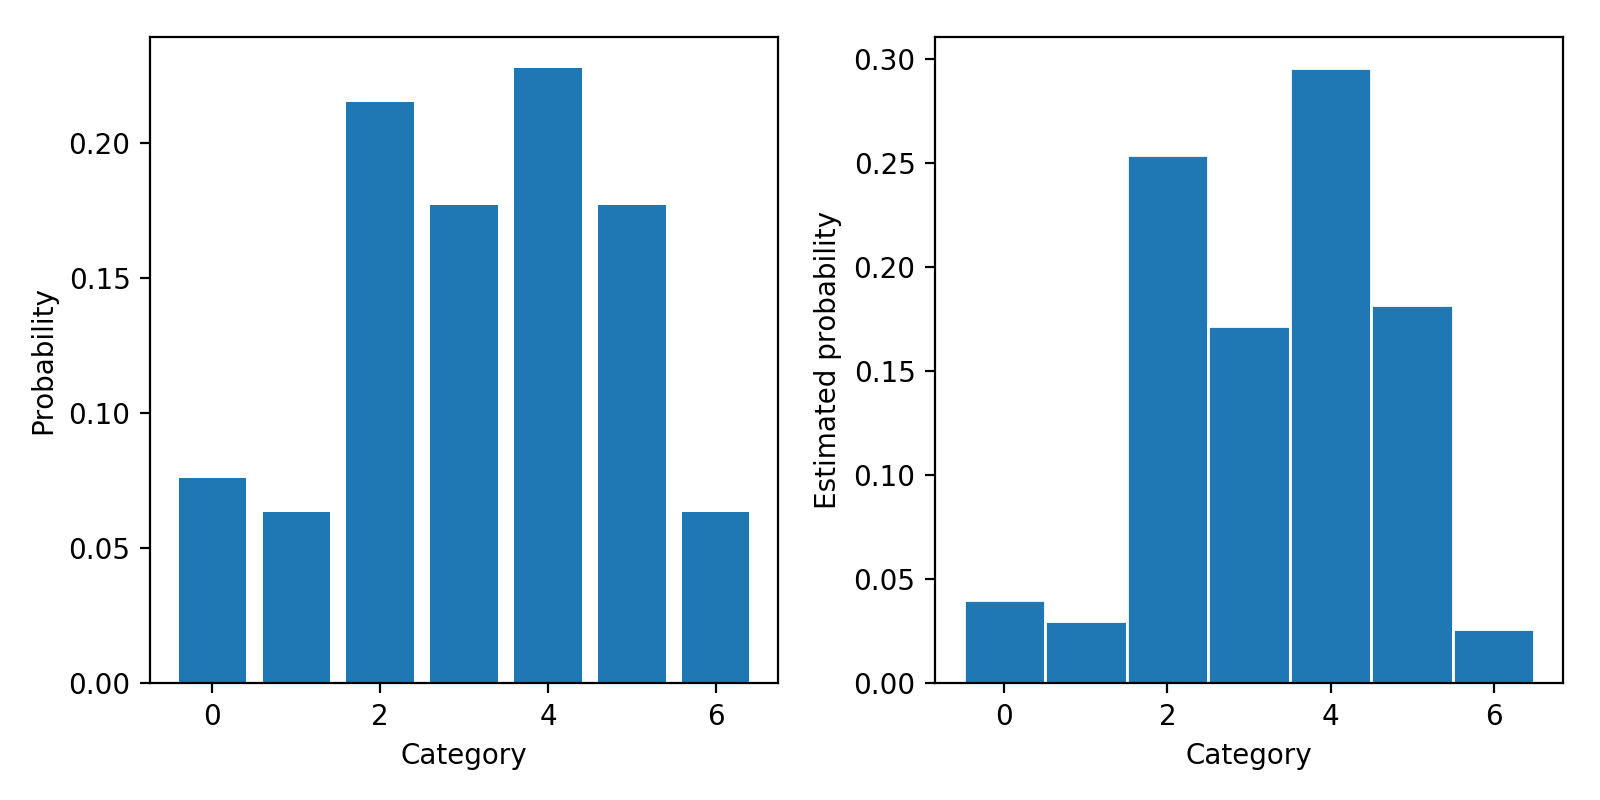

Original probabilities:		0.08 0.06 0.22 0.18 0.23 0.18 0.06
Estimated probabilities:	0.04 0.03 0.25 0.17 0.30 0.18 0.03


In [9]:
def sample(logits):
    noise = np.random.normal(size=len(logits))
    sample = argmax(logits + noise)
    return sample

samples = [sample(logits) for _ in range(n_samples)]

figure()
subplot(1, 2, 1)
plot_probs()
subplot(1, 2, 2)
estd_probs = plot_estimated_probs(samples)
tight_layout()

print("Original probabilities:\t\t", end="")
print_probs(probs)
print("Estimated probabilities:\t", end="")
print_probs(estd_probs)

So normal noise seems to do a better job of capturing the full range of categories, but still distorts the probabilities.

We're getting closer, though. Maybe there's a special kind of noise that gives the right results?

It turns out the 'special kind of noise' happens to be noise from a Gumbel distribution!

### Gumbel noise

<IPython.core.display.Javascript object>


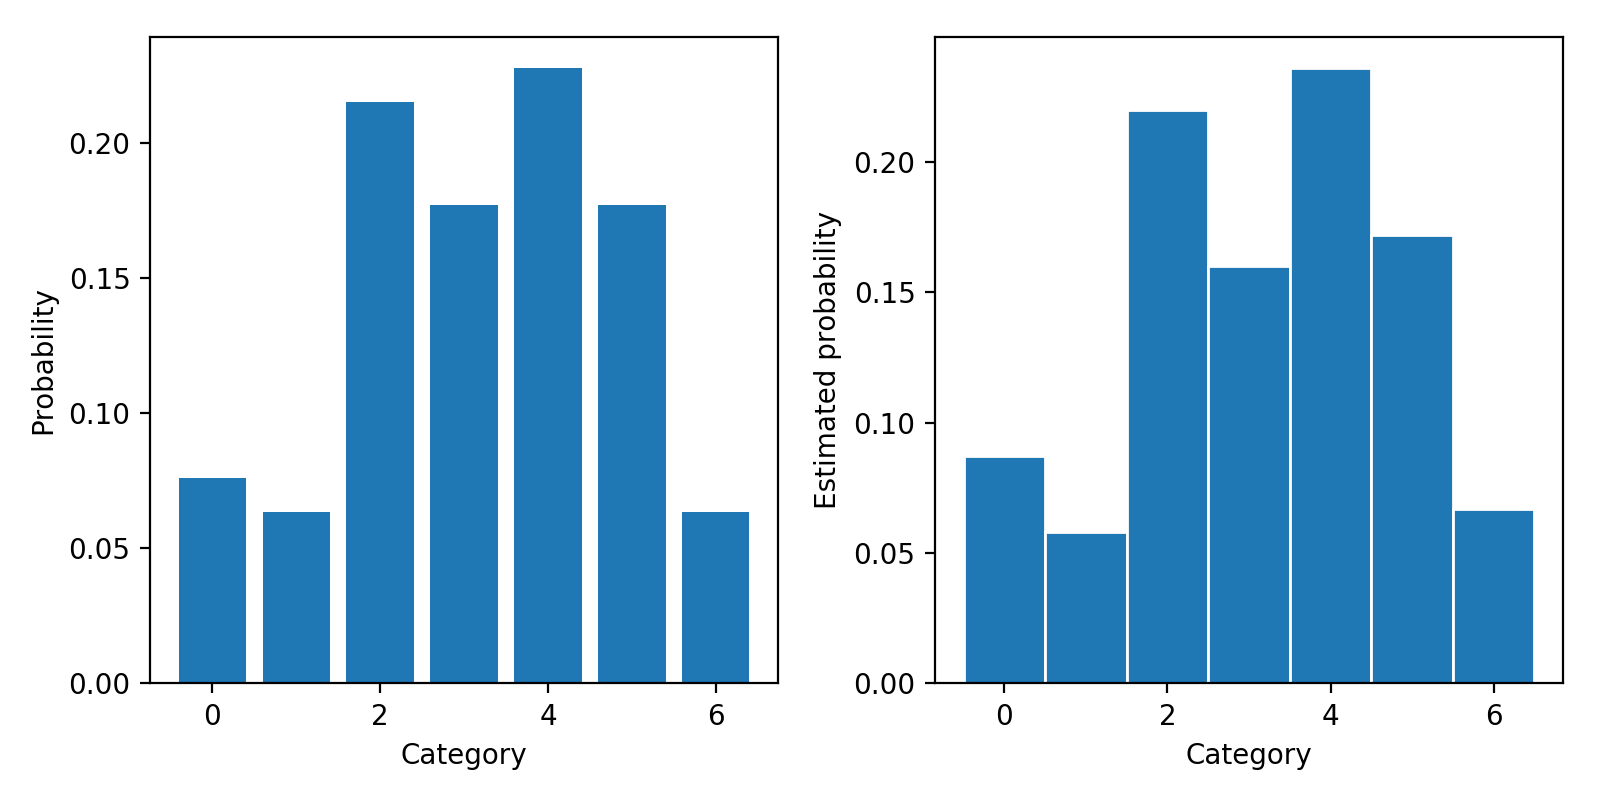

Original probabilities:		0.08 0.06 0.22 0.18 0.23 0.18 0.06
Estimated probabilities:	0.09 0.06 0.22 0.16 0.24 0.17 0.07


In [11]:
def sample(logits):
    noise = np.random.gumbel(size=len(logits))
    sample = argmax(logits + noise)
    return sample

samples = [sample(logits) for _ in range(n_samples)]

figure()
subplot(1, 2, 1)
plot_probs()
subplot(1, 2, 2)
estd_probs = plot_estimated_probs(samples)
tight_layout()

print("Original probabilities:\t\t", end="")
print_probs(probs)
print("Estimated probabilities:\t", end="")
print_probs(estd_probs)

With Gumbel noise, we get exactly the right probabilities! (At least, similarly as close to the original probabilities as we got by sampling with `np.random.choice`.)

Note that we get the probabilities despite the fact that we were operating on the _logits_ - _not_ on the post-softmax probabilities themselves.

Why is it that Gumbel noise happens to be exactly the right kind of noise to make this work? Sadly, I haven't been able to come up with an _intuitive_ explanation for why this is the case. If you're into proofs, though, the Harvard Intelligent Probabilistic Systems Group do have something easy-to-follow at _[The Gumbel-Max Trick for Discrete Distributions](https://hips.seas.harvard.edu/blog/2013/04/06/the-gumbel-max-trick-for-discrete-distributions)_.

### Generating Gumbel noise

What if we only had access to a uniform noise generator? It turns out we can still generate Gumbel noise by starting with uniform noise and then taking the negative log twice. This is exactly what we see in OpenAI's code.

<IPython.core.display.Javascript object>


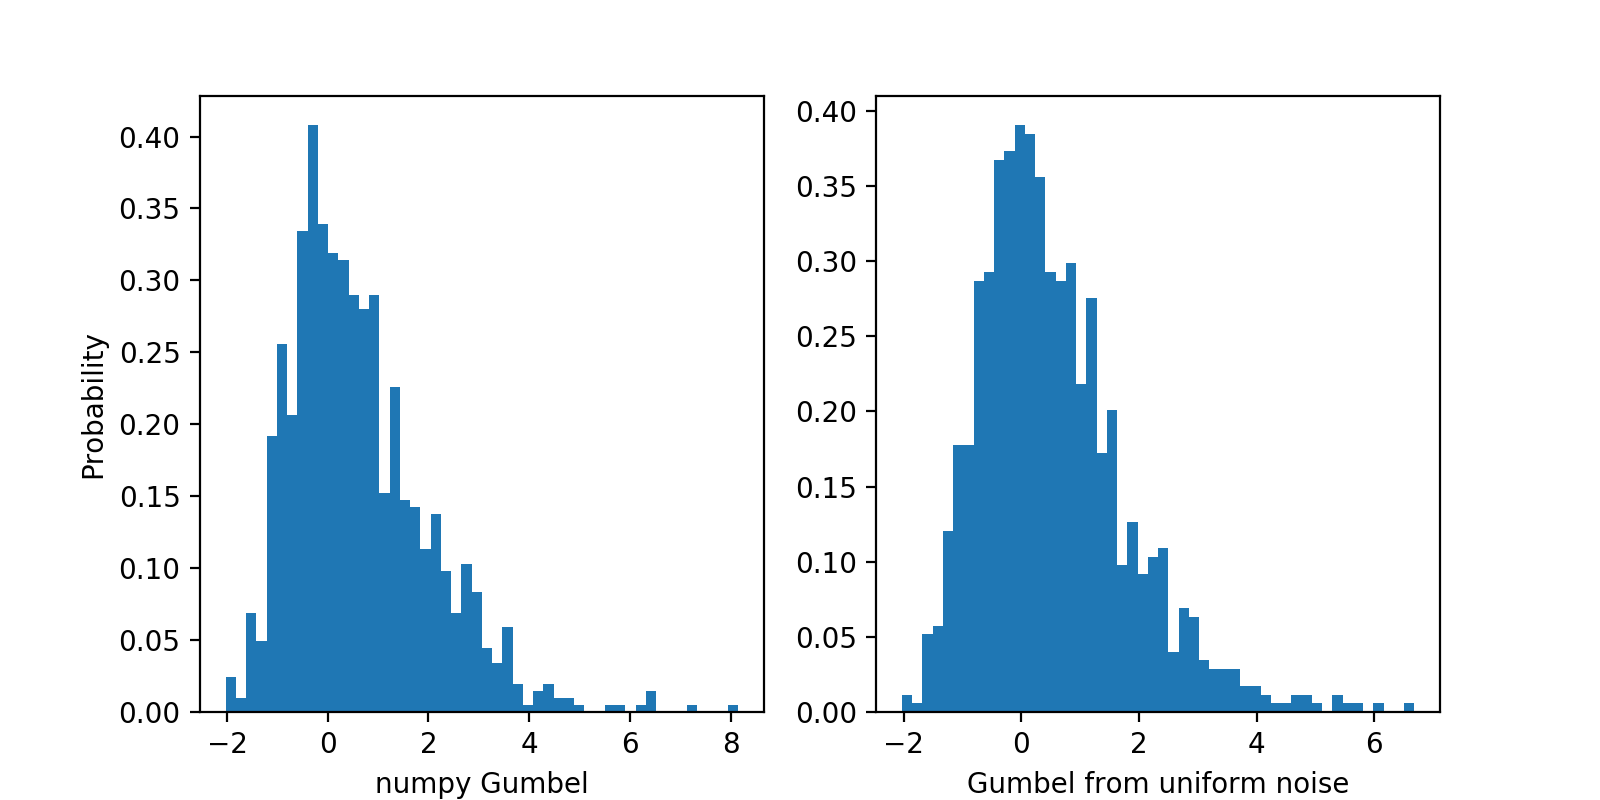

In [14]:
numpy_gumbel = np.random.gumbel(size=n_samples)
manual_gumbel = -log(-log(np.random.uniform(size=n_samples)))
figure()
subplot(1, 2, 1)
hist(numpy_gumbel, bins=50, density=True)
ylabel("Probability")
xlabel("numpy Gumbel")
subplot(1, 2, 2)
hist(manual_gumbel, bins=50, density=True)
xlabel("Gumbel from uniform noise");

### Why sample with Gumbel noise?

Sampling this way is called the **Gumbel-max trick**.

If all you care about is drawing samples, it's not clear to me why you'd use the Gumbel-max trick rather than `np.random.choice` (or e.g. `tf.multinomial`). One neat thing pointed out by [Tim Vieira](http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/) is that if you precompute the noise, Gumbel-max sampling can be a lot faster than the traditional method of sampling. But in cases where sampling speed isn't a bottleneck, I don't think the tradeoff in readability is worth it.

However, it turns out that with a little more work, we can do something really interesting with the Gumbel-max trick.

## The Gumbel-softmax trick

Remember, the Gumbel-max trick produces a sample by adding noise to the logits then taking the argmax of the resulting vector. So far, there's nothing so special about Gumbel-max sampling.

But what if we replaced the argmax by a softmax? Then something really interesting happens: we have a chain of operations that's _fully differentiable_. We have  _differentiable sampling operator_ (albeit with a one-hot output instead of a scalar). Wow!

<img src="gumbel.png" style="width: 100%; max-width: 500px"/>

### TensorFlow example

Let's convince ourselves that this really works with a quick example.

In [15]:
import tensorflow as tf
sess = tf.Session()

def differentiable_sample(logits):
    noise = tf.random_uniform(tf.shape(logits))
    logits_with_noise = logits - tf.log(-tf.log(noise))
    return tf.nn.softmax(logits_with_noise)

Let's set up a normal distribution parameterised by some variable representing the mean.

In [16]:
mean = tf.Variable(2.)
idxs = tf.Variable([0., 1., 2., 3., 4.])
# An unnormalised approximately-normal distribution
logits = tf.exp(-(idxs - mean) ** 2)
sess.run(tf.global_variables_initializer())

def print_logit_vals():
    logit_vals = sess.run(logits)
    print(" ".join(["{:.2f}"] * len(logit_vals)).format(*logit_vals))
    
print("Logits: ", end="")
print_logit_vals()

Logits: 0.02 0.37 1.00 0.37 0.02


Let's sample from this distribution, then calculate a value based on the sample such that higher samples give larger results.

In [17]:
sample = differentiable_sample(logits)
sample_weights = tf.Variable([1., 2., 3., 4., 5.], trainable=False)
result = tf.reduce_sum(sample * sample_weights)

Finally, let's use gradient descent to try and maximize that final value. Since we get larger values for higher samples, we expect the mean of the distribution to shift upwards.

In [19]:
sess.run(tf.global_variables_initializer())
train_op = tf.train.GradientDescentOptimizer(learning_rate=1).minimize(-result)

print("Distribution mean: {:.2f}".format(sess.run(mean)))
for i in range(5):
    sess.run(train_op)
    print("Distribution mean: {:.2f}".format(sess.run(mean)))

Distribution mean: 2.00
Distribution mean: 2.30
Distribution mean: 2.61
Distribution mean: 2.91
Distribution mean: 2.92
Distribution mean: 3.20


It worked! We were able to back-propagate all the way to the parameter of the distribution.

### When is the Gumbel-softmax trick useful?

In general, the Gumbel-softmax trick is interesting whenever we're in the following situation:

* We have logits computed using some parameters
* Those logits are converted to a probability distribution
* We take a sample from the distribution
* We have some downstream effect (e.g. a loss) that's calculated based on the sample
* We want to calculate how to change the parameters in order to change the downstream effect

In short, Gumbel-softmax is interesting whenever we want gradients of something downstream of sampling.

(It's interesting to compare this to the usual setup for supervised learning for classification. There, loss is calculated based on cross-entropy between the predicted distribution over class labels and a one-hot vector representing the correct class label. In contrast to the situation described above, in classification, the loss is calculated based on the _probability distribution itself_, rather than on a _sample_ from the distribution.)

### Gumbel-softmax in the wild: reinforcement learning

Bringing us full-circle back to reinforcement learning, for an example of the Gumbel-softmax trick used in the real world, we can take a quick look at OpenAI's recent [Learning to Communicate](https://blog.openai.com/learning-to-communicate) paper.

Their setup involved multiple agents cooperating to achieve shared goals. The agents communicate their goals to each other (e.g. "Look at the green landmark") through a simple language which develops during training.

<img src="learning-to-communicate.png" style="width: 100%; max-width: 400px"/><sup>Image source: [Learning to Communicate](https://blog.openai.com/learning-to-communicate)</sup>

Words in the language are sampled from a probability distribution that's a function of what each agent sees. Using the Gumbel-softmax trick meant that sampling of words was differentiable, and therefore _so was the whole communication channel_. With a _differentiable communication channel_, they were able to _calculate_ how each agent should change what it said in order for all agents to achieve better reward.

This is a really exciting thing to be able to do. More generally, having a differentiable means of sampling actions, and therefore being able to back-propagate _through other agents' actions_ - this could open the gates for a whole bunch of new possibilities in cooperative reinforcement learning. OpenAI's blog post notes that there are other ways to do it, but the Gumbel-softmax trick just makes it so easy.

## Summary

We've taken a look at the Gumbel distribution, the Gumbel-max trick for generating samples, and the Gumbel-softmax trick for differentiable sampling.

If you'd like to read more, there are two main papers which seem to be responsible for revitalising interesting in the various Gumbel tricks. You'll find lots of details there:
* Jang, Gu and Poole's [Categorical Reparameterization with Gumbel-Softmax](https://arxiv.org/pdf/1611.01144.pdf) (with a summary at [Tutorial: Categorical Variational Autoencoders using Gumbel-Softmax](https://blog.evjang.com/2016/11/tutorial-categorical-variational.html))
* Maddison, Mnih and Teh's [The Concrete Distribution: A Continuous Relaxation of Discrete Random Variables](https://arxiv.org/pdf/1611.00712.pdf)